# Visualize GOES-16 Data from S3

#### This code retrieves a GOES-16 NetCDF file from the S3 bucket and visualize it. GOES makes 4 measurements in each hour, and only the first one is retrieved here. 

In [1]:
import xarray as xr
import requests
import netCDF4
import boto3
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bucket_name = 'noaa-goes16'
product_name = 'ABI-L1b-RadF'
year = 2019
day_of_year = 79
hour = 12
band = 3

In [3]:
# Initialize s3 client. Make sure to enter your AWS credentials.
# You comment out the `aws_access_key_id` and `aws_secret_access_key` 
# if you have aws cli installed and configured on your computer.
s3_client = boto3.client('s3',
                         aws_access_key_id = 'YOUR_AWS_ACCESS_KEY_ID',
                         aws_secret_access_key = 'YOUR_AWS_SECRET_ACCESS_KEY'
                        )

In [4]:
def get_s3_keys(bucket, s3_client, prefix = ''):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:
        resp = s3_client.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            if key.startswith(prefix):
                yield key

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

In [5]:
keys = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M3C{band:02.0f}'
                  )


key = [key for key in keys][0] # selecting the first measurement taken within the hour

In [6]:
resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{key}')

In [7]:
file_name = key.split('/')[-1].split('.')[0]
nc4_ds = netCDF4.Dataset(file_name, memory = resp.content)
store = xr.backends.NetCDF4DataStore(nc4_ds)
DS = xr.open_dataset(store)

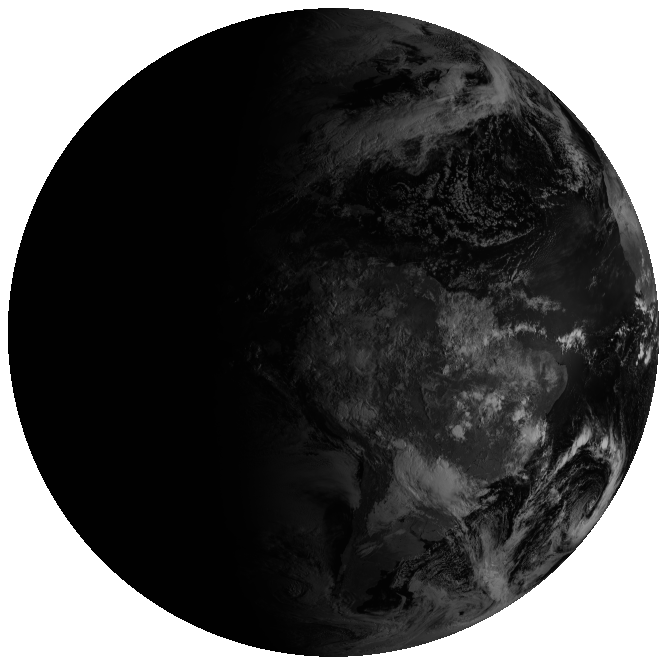

In [8]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(DS.Rad, cmap='gray')
plt.axis('off')
plt.savefig(f'{file_name}.png', dpi=300, facecolor='w', edgecolor='w')